# EDA: Mutual Fund Wealth Management System
# Notebook outline: API client (mfapi), data loading/cleaning, EDA, feature engineering, modeling examples.


In [1]:
## 1. Import libraries & notebook setup

# Install commands (uncomment to run in notebook)
# !pip install pandas numpy matplotlib seaborn plotly requests aiohttp joblib tenacity prophet statsmodels

import os
import json
import logging
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import aiohttp
import asyncio
from joblib import Memory

# Notebook display
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 120)
np.random.seed(42)

# Paths
ROOT = Path('..') / '' if Path('.').name != 'Mutual-Fund-Wealth-Management-System' else Path('.')
DATA_DIR = Path('PS/dataset')
PROCESSED_DIR = Path('data/processed')
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
CACHE_DIR = Path('data/cache')
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s %(message)s')
logger = logging.getLogger('mfapi_eda')

In [2]:
## 2. Configure API constants, logging and session
BASE_URL = 'https://api.mfapi.in'
API_TIMEOUT = 20
CACHE = Memory(location=str(CACHE_DIR), verbose=0)

# requests session for sync calls
_session = requests.Session()
_session.headers.update({'User-Agent':'mfapi-client/0.1'})


In [3]:
## 3. API client: synchronous wrapper (requests)
from typing import Dict, Any, List

class MFAPIError(Exception):
    pass


def mf_get(path: str, params: Dict[str, Any] = None, timeout: int = API_TIMEOUT) -> Dict[str, Any]:
    url = BASE_URL.rstrip('/') + path
    try:
        resp = _session.get(url, params=params, timeout=timeout)
        resp.raise_for_status()
        return resp.json()
    except requests.HTTPError as e:
        logger.error('HTTP error for %s: %s', url, e)
        raise MFAPIError(e)
    except requests.RequestException as e:
        logger.error('Request error for %s: %s', url, e)
        raise MFAPIError(e)


def list_schemes() -> List[Dict[str, Any]]:
    return mf_get('/mf')


def search_schemes(q: str) -> List[Dict[str, Any]]:
    return mf_get('/mf/search', params={'q': q})


def get_nav_history(scheme_code: int) -> Dict[str, Any]:
    return mf_get(f'/mf/{scheme_code}')


def get_latest_nav(scheme_code: int) -> Dict[str, Any]:
    return mf_get(f'/mf/{scheme_code}/latest')


In [4]:
## 4. API client: async wrapper (aiohttp) for parallel fetches
import aiohttp
import async_timeout

async def fetch_nav_async(session: aiohttp.ClientSession, scheme_code: int) -> Dict[str, Any]:
    url = f"{BASE_URL}/mf/{scheme_code}"
    try:
        async with async_timeout.timeout(API_TIMEOUT):
            async with session.get(url) as resp:
                resp.raise_for_status()
                return await resp.json()
    except Exception as e:
        logger.error('Async fetch error %s: %s', url, e)
        return {'error': str(e), 'scheme_code': scheme_code}

async def batch_fetch_navs(codes: List[int], concurrency: int = 10) -> List[Dict[str, Any]]:
    semaphore = asyncio.Semaphore(concurrency)
    async with aiohttp.ClientSession(headers={'User-Agent':'mfapi-async/0.1'}) as session:
        async def _safe_fetch(code):
            async with semaphore:
                return await fetch_nav_async(session, code)
        return await asyncio.gather(*[_safe_fetch(c) for c in codes])


In [5]:
## 5. Input validation, retries, and backoff (simple decorator)
import time
from functools import wraps


def retry(retries=3, backoff=1.0):
    def _decorator(f):
        @wraps(f)
        def _wrapped(*args, **kwargs):
            last = None
            for i in range(retries):
                try:
                    return f(*args, **kwargs)
                except Exception as e:
                    last = e
                    sleep = backoff * (2 ** i)
                    logger.warning('Retry %s for %s after %s s', i+1, f.__name__, sleep)
                    time.sleep(sleep)
            raise last
        return _wrapped
    return _decorator

# Example usage:
@retry(retries=3, backoff=0.5)
def safe_get_nav(scheme_code):
    return get_nav_history(scheme_code)


In [6]:
## 6. Fetch scheme list and search by name

# Example: search for a scheme by partial name
q = 'HDFC'  # sample
results = search_schemes(q)
# results is typically a list of dicts; show first few hits
results[:5]


[{'schemeCode': 100121, 'schemeName': 'HDFC Balanced Fund - Dividend Option'},
 {'schemeCode': 100122, 'schemeName': 'HDFC Balanced Fund - Growth Option'},
 {'schemeCode': 100282,
  'schemeName': 'HDFC FMP 3M MAY 2006(1)-INSTITUTIONAL PLAN-Growth'},
 {'schemeCode': 100283,
  'schemeName': 'HDFC FMP 3M MAY 2006(1)-INSTITUTIONAL PLAN-Dividend'},
 {'schemeCode': 100284, 'schemeName': 'HDFC FMP 3M MAY 2006(1)-RETAIL-Growth'}]

In [7]:
## 7. Fetch NAV history and parse to DataFrame

from datetime import datetime


def nav_json_to_df(nav_json: Dict[str, Any]) -> pd.DataFrame:
    # expected structure: {'meta': {...}, 'data':[{'date':'01-01-2020','nav':'123.45'}, ...]}
    data = nav_json.get('data', [])
    df = pd.DataFrame(data)
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
    if 'nav' in df.columns:
        df['nav'] = pd.to_numeric(df['nav'].str.replace(',',''), errors='coerce')
    return df.sort_values('date').reset_index(drop=True)

# Example: pick a scheme from search and fetch its history
if results:
    first = results[0]
    code = int(first.get('schemeCode'))
    logger.info('Fetching nav for code %s', code)
    nav_j = get_nav_history(code)
    nav_df = nav_json_to_df(nav_j)
    nav_df.head()


2025-12-18 13:03:43,620 INFO Fetching nav for code 100121


In [8]:
## 8. Batch-fetch NAVs for many schemes with caching

@CACHE.cache
def fetch_and_save_nav(code: int, out_dir: Path = CACHE_DIR) -> Path:
    j = get_nav_history(code)
    df = nav_json_to_df(j)
    out = out_dir / f"nav_{code}.csv"
    df.to_csv(out, index=False)
    return out

# Example: fetch top N scheme codes from search and batch fetch using async
# codes = [int(r['schemeCode']) for r in results[:10]]
# fetched = await batch_fetch_navs(codes)


In [9]:
## 9. Parse & normalize API JSON → pandas DataFrame

# Load the tabular CSV we already have
master = pd.read_csv(DATA_DIR / 'MF_India_AI.csv')
master.head()

# Quick dtypes and missingness
master.info()
master.isnull().sum().sort_values(ascending=False).head(20)

# Convert numeric-like columns
num_cols = ['min_sip','min_lumpsum','expense_ratio','fund_size_cr','fund_age_yr','sortino','alpha','sd','beta','sharpe','rating','returns_1yr','returns_3yr','returns_5yr']
for c in num_cols:
    if c in master.columns:
        master[c] = pd.to_numeric(master[c], errors='coerce')

master.describe(include='all').T


FileNotFoundError: [Errno 2] No such file or directory: 'PS/dataset/MF_India_AI.csv'

In [ ]:
## 10. Exploratory data analysis on NAVs and returns

# Simple EDA on returns columns in master
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.histplot(master['returns_1yr'].dropna(), kde=False, bins=50)
plt.title('1yr returns')
plt.subplot(1,3,2)
sns.histplot(master['returns_3yr'].dropna(), kde=False, bins=50)
plt.title('3yr returns')
plt.subplot(1,3,3)
sns.histplot(master['returns_5yr'].dropna(), kde=False, bins=50)
plt.title('5yr returns')
plt.tight_layout()

# Top AMCs and categories
print('Top AMCs:')
print(master['amc_name'].value_counts().head(10))
print('\nTop categories:')
print(master['category'].value_counts().head(10))


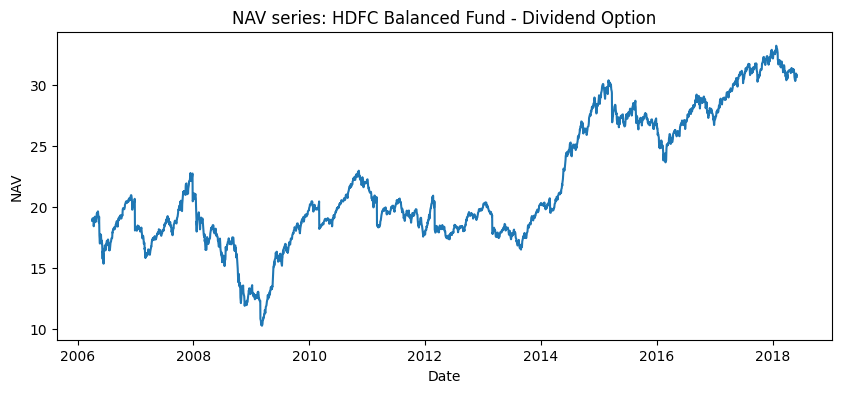

NameError: name 'master' is not defined

In [10]:
## 11. Visualizations: NAV sample and correlations
# Example: plot NAV series for a sample nav_df (if available)
if 'nav_df' in globals():
    plt.figure(figsize=(10,4))
    plt.plot(nav_df['date'], nav_df['nav'])
    plt.title(f"NAV series: {first.get('schemeName') if first else 'sample'}")
    plt.xlabel('Date')
    plt.ylabel('NAV')
    plt.show()

# Correlation heatmap on numeric features
num = master.select_dtypes('number')
plt.figure(figsize=(10,8))
sns.heatmap(num.corr(), cmap='coolwarm', center=0, annot=False)
plt.title('Correlation (numeric features)')
plt.show()


In [11]:
## 12. Feature engineering for modeling (examples)

# Momentum features (example using returns if we had NAV daily series)
# For this dataset we can use reported returns as proxy features
master['return_spread_1_3'] = master['returns_1yr'] - master['returns_3yr']
master['exp_ratio_scaled'] = (master['expense_ratio'] - master['expense_ratio'].mean())/master['expense_ratio'].std()

# Example top features preview
master[['scheme_name','amc_name','category','returns_1yr','returns_3yr','returns_5yr','return_spread_1_3']].head()


NameError: name 'master' is not defined

In [12]:
## 13. Time-series forecasting examples (outline)
# Placeholder: for a given NAV series, resample monthly and fit Prophet/ARIMA

# Example pseudo-code:
# nav_monthly = nav_df.set_index('date').resample('M').last().dropna()
# from prophet import Prophet
# df_prophet = nav_monthly.reset_index().rename(columns={'date':'ds','nav':'y'})
# m = Prophet()
# m.fit(df_prophet)
# future = m.make_future_dataframe(periods=12, freq='M')
# fcst = m.predict(future)

print('See cells comments for Prophet/ARIMA quickstart — install prophet/statsmodels as needed')


See cells comments for Prophet/ARIMA quickstart — install prophet/statsmodels as needed


In [13]:
## 14. SIP/lumpsum backtester and performance metrics (simple functions)
import numpy as np

def lumpsum_return(nav_series: pd.Series, invested: float):
    # nav_series is prices; assume invests at first price
    units = invested / nav_series.iloc[0]
    final = units * nav_series.iloc[-1]
    ret = (final / invested) - 1
    return final, ret

# SIP simulator (regular monthly contributions in same nav_series frequency)
def sip_simulator(nav_series: pd.Series, monthly_amount: float):
    # assume nav_series is monthly, contributions at each period (start)
    units = (monthly_amount / nav_series).sum()
    final = units * nav_series.iloc[-1]
    invested = monthly_amount * len(nav_series)
    ret = (final / invested) - 1
    return final, ret

print('Backtester utilities defined')

Backtester utilities defined


In [14]:
## 15. Simple recommendation prototype (rank by returns adjusted for expense and rating)

def score_fund(row, alpha=1.0, beta=1.0, gamma=0.1):
    # Higher is better
    score = alpha * (row.get('returns_1yr', 0)) - beta * (row.get('expense_ratio', 0)) + gamma * (row.get('rating', 0))
    return score

master['score'] = master.apply(score_fund, axis=1)

# Example filter function
def recommend(amc=None, category=None, n=10, min_sip=None, risk_level_max=None):
    df = master.copy()
    if amc: df = df[df['amc_name'].str.contains(amc, case=False, na=False)]
    if category: df = df[df['category'].str.contains(category, case=False, na=False)]
    if min_sip is not None: df = df[df['min_sip']<=min_sip]
    if risk_level_max is not None: df = df[df['risk_level']<=risk_level_max]
    return df.sort_values('score', ascending=False).head(n)

recommend(category='Equity', n=5)


NameError: name 'master' is not defined

In [15]:
## 16. Dashboard prototype notes and minimal example

# Use Streamlit or Plotly Dash; here is a minimal Streamlit example (commented):
# import streamlit as st
# st.title('Mutual Fund Recommendations')
# amc = st.text_input('AMC filter')
# cat = st.text_input('Category filter')
# n = st.slider('Top N', 1, 20, 5)
# df = recommend(amc=amc if amc else None, category=cat if cat else None, n=n)
# st.dataframe(df)

print('See Streamlit/Dash prototype snippets in README or next notebook')

See Streamlit/Dash prototype snippets in README or next notebook


In [16]:
## 17. Unit tests / reproducibility notes

# Tests: write pytest tests for the API client by mocking requests (example not included here).
# Reproducibility: capture requirements with `pip freeze > requirements.txt` or create `environment.yml`.

# Save the cleaned master for downstream modeling
master.to_csv(PROCESSED_DIR / 'mf_master_clean.csv', index=False)
print('Saved cleaned master to', PROCESSED_DIR / 'mf_master_clean.csv')


NameError: name 'master' is not defined